In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('/content/drive/MyDrive/transaction_fraud_data.parquet')
df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


Проверим процентное соотношение мошеннических и не мошеннических операций

Проценты:
is_fraud
False    80.03
True     19.97
Name: count, dtype: float64


/tmp/ipython-input-13-127240412.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_percent.index, y=fraud_percent.values, palette="Set2")


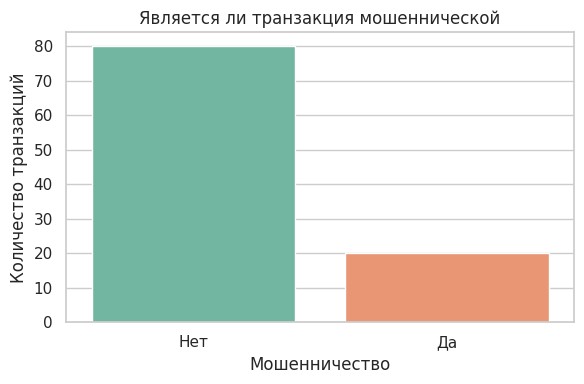

In [13]:
fraud_counts = df['is_fraud'].value_counts()
fraud_percent = fraud_counts / df.shape[0] * 100

print("Проценты:")
print(fraud_percent.round(2))


sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_percent.index, y=fraud_percent.values, palette="Set2")
plt.title("Является ли транзакция мошеннической")
plt.ylabel("Количество транзакций в %")
plt.xlabel("Мошенничество")
plt.xticks([0, 1], ['Нет', 'Да'])
plt.tight_layout()
plt.show()

Процент мошеннических операций ≈ 20%, что является достаточно высоким значением, в реальной жизни процент мошеннических операций колеблется от 0.1% до 2% (данные из открытых источников). Скорее всего данные искусственно сбалансированы или содержат выборку, в которой мошенничество преувеличено для целей анализа/обучения модели

Попробуем проанализировать составное поле `last_hour_activity`, про него известно следующее:

| Ключ | Описание | Тип |
|------|----------|-----|
| `num_transactions` | Количество транзакций | Int64 |
| `total_amount` | Общая сумма транзакций | Float64 |
| `unique_merchants` | Число уникальных продавцов | Int64 |
| `unique_countries` | Число уникальных стран | Int64 |
| `max_single_amount` | Максимальная сумма одной транзакции | Float64 |

**Гипотеза:** некоторые из этих признаков могут быть достаточно сильно смещены у мошеннических операций. Для этого сравним медианные значения у всех признаков в поле `last_hour_activity`

In [7]:
def extract_stat(df, key):
    return df['last_hour_activity'].apply(lambda x: x[key] if pd.notnull(x) else None)

results = {}

for key in ['num_transactions', 'total_amount', 'unique_merchants', 'unique_countries', 'max_single_amount']:
    fraud_values = df[df['is_fraud'] == True]['last_hour_activity'].apply(lambda x: x[key])
    nonfraud_values = df[df['is_fraud'] == False]['last_hour_activity'].apply(lambda x: x[key])

    results[key] = {
        'Fraud Median': fraud_values.median(),
        'Non-Fraud Median': nonfraud_values.median(),
        'Delta': fraud_values.median() - nonfraud_values.median(),
    }
    results[key]['Delta (percent)'] = results[key]['Delta'] / df.shape[0] * 100


results_df = pd.DataFrame(results).T.sort_values(by='Delta', ascending=False)
print("Разница медиан по вложенным признакам last_hour_activity:")
print(results_df.round(2))

Разница медиан по вложенным признакам last_hour_activity:
                   Fraud Median  Non-Fraud Median      Delta  Delta (percent)
total_amount        10375723.48       10129469.46  246254.02             3.29
max_single_amount    1267038.24        1229527.20   37511.04             0.50
num_transactions         296.00            292.00       4.00             0.00
unique_merchants          95.00             95.00       0.00             0.00
unique_countries          12.00             12.00       0.00             0.00


Гипотеза не подтвердилась, отклонение в % крайне незначительное

Проверим, есть ли различия в сумме транзакций `amount`. Для этого вычислим медианные значения

In [10]:
fraud_amount = df[df['is_fraud'] == True]['amount']
nonfraud_amount = df[df['is_fraud'] == False]['amount']

median_fraud = fraud_amount.median()
median_nonfraud = nonfraud_amount.median()
delta = median_fraud - median_nonfraud
delta_percent = (delta / median_nonfraud) * 100

print(f"Медианное значение мошеннических операций: {median_fraud:.2f}")
print(f"Медиана значение не мошеннических операций: {median_nonfraud:.2f}")
print(f"Разница: {delta:.2f} ({delta_percent:.2f}%)")

Медианное значение мошеннических операций: 5626.06
Медиана значение не мошеннических операций: 903.51
Разница: 4722.55 (522.69%)


Также построим диаграмму размаха (ящик с усами)

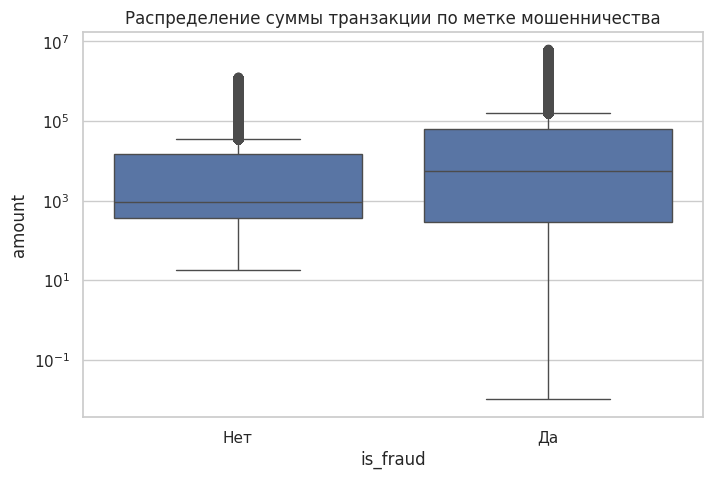

In [9]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_fraud', y='amount', data=df)
plt.yscale('log')
plt.title('Распределение суммы транзакции по метке мошенничества')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.show()

Мошеннические транзакции в среднем гораздо крупнее по сумме — более чем в 5 раз.

**Вывод**: для предотвращения мошеннических операций стоит уделять большее внимание бОльшим транзакциям

Дополнительно разобьём суммы транзакций на три группы



*   Низкое значение транзакции - до 33 процентиля
*   Среднее значение транзакции - от 33 до 66 процентиля
*   Высокое значение транзакции - выше 66 процентиля



Fraud rate по категориям суммы транзакций (%):
amount_category
High      28.16
Low       17.02
Medium    14.49
Name: is_fraud, dtype: float64


/tmp/ipython-input-5-4277158608.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_rate_by_amount.index, y=fraud_rate_by_amount.values, palette='muted')


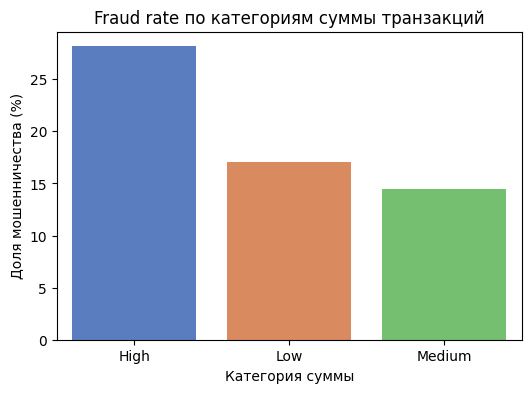

In [5]:
low_thresh = df['amount'].quantile(0.33)
high_thresh = df['amount'].quantile(0.66)

def categorize_amount(amount):
    if amount <= low_thresh:
        return 'Low'
    elif amount <= high_thresh:
        return 'Medium'
    else:
        return 'High'


df['amount_category'] = df['amount'].apply(categorize_amount)

fraud_rate_by_amount = df.groupby('amount_category')['is_fraud'].mean() * 100

print("Fraud rate по категориям суммы транзакций (%):")
print(fraud_rate_by_amount.round(2))

plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_rate_by_amount.index, y=fraud_rate_by_amount.values, palette='muted')
plt.ylabel('Доля мошенничества (%)')
plt.xlabel('Категория суммы')
plt.title('Fraud rate по категориям суммы транзакций')
plt.show()

Выоды:

**Высокие суммы (High)** — имеют значительно более высокий уровень мошенничества (28.16%), это ожидаемо, ведь крупные транзакции привлекают мошенников.

**Низкие суммы (Low)** показывают довольно высокий уровень мошенничества (17.02%), выше среднего. Это может означать, что мошенники также активно проводят мелкие транзакции, возможно, для того, чтобы не привлекать к себе лишнее внимание или отрабатывать мошеннические схемы.



Дополнительно проверим каналы проведения мошеннических транзакций

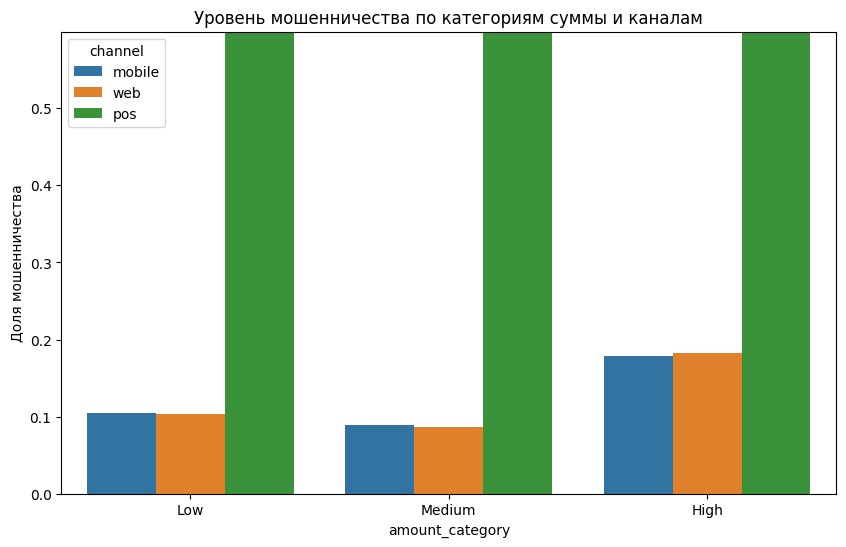

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='amount_category', y='is_fraud', hue='channel', errorbar=None)
plt.ylabel('Доля мошенничества')
plt.title('Уровень мошенничества по категориям суммы и каналам')
plt.ylim(0, df['is_fraud'].mean() * 3)
plt.show()

**Вывод**: из столбчатой диаграммы видно, что наиболее часто мошенничество встречается среди канала POS, что достаточно странно, учитывая, что POS традиционно считаются наименее уязвимыми к мошенническим операциям. Возможно, что в датасете собраны такие данные, что в категории POS находятся только мошеннические операции

In [8]:
print(df['channel'].value_counts(normalize=True) * 100)
print(df.groupby('channel')['is_fraud'].mean() * 100)

channel
web       60.973860
mobile    30.326683
pos        8.699457
Name: proportion, dtype: float64
channel
mobile     12.387765
pos       100.000000
web        12.327517
Name: is_fraud, dtype: float64


Действительно, в датасете все операции в `channel`, относящиеся к POS являются мошенническими, хотя всего таких данных не слишком много, порядка 9%. Скорее всего этого особенность датасета, необходимо уточнить этот момент.


Делаем вывод, что все значения в поле `channel`, относящиеся к POS являются бесполезными и их можно и нужно удалить

Заново выполним расчёты, проведённые ранее, теперь уже без POS

In [3]:
df = df[df['channel'] != 'pos']

Выполним пересчёт количества мошеннических и не мошеннических операций

Проценты:
is_fraud
False    87.65
True     12.35
Name: count, dtype: float64


/tmp/ipython-input-4-3309695541.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_percent.index, y=fraud_percent.values, palette="Set2")


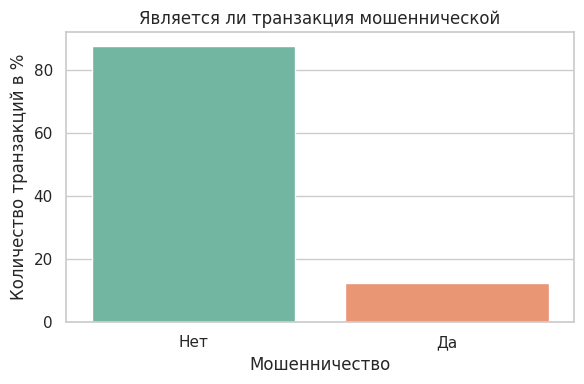

In [4]:
fraud_counts = df['is_fraud'].value_counts()
fraud_percent = fraud_counts / df.shape[0] * 100

print("Проценты:")
print(fraud_percent.round(2))


sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_percent.index, y=fraud_percent.values, palette="Set2")
plt.title("Является ли транзакция мошеннической")
plt.ylabel("Количество транзакций в %")
plt.xlabel("Мошенничество")
plt.xticks([0, 1], ['Нет', 'Да'])
plt.tight_layout()
plt.show()

После удаления всех POS-операций доля мошеннических операций упала с 19.97 до 12.35

Снова проверим активность за последний час

In [5]:
def extract_stat(df, key):
    return df['last_hour_activity'].apply(lambda x: x[key] if pd.notnull(x) else None)

results = {}

for key in ['num_transactions', 'total_amount', 'unique_merchants', 'unique_countries', 'max_single_amount']:
    fraud_values = df[df['is_fraud'] == True]['last_hour_activity'].apply(lambda x: x[key])
    nonfraud_values = df[df['is_fraud'] == False]['last_hour_activity'].apply(lambda x: x[key])

    results[key] = {
        'Fraud Median': fraud_values.median(),
        'Non-Fraud Median': nonfraud_values.median(),
        'Delta': fraud_values.median() - nonfraud_values.median(),
    }
    results[key]['Delta (percent)'] = results[key]['Delta'] / df.shape[0] * 100


results_df = pd.DataFrame(results).T.sort_values(by='Delta', ascending=False)
print("Разница медиан по вложенным признакам last_hour_activity:")
print(results_df.round(2))

Разница медиан по вложенным признакам last_hour_activity:
                   Fraud Median  Non-Fraud Median      Delta  Delta (percent)
total_amount        10351003.45       10129469.46  221534.00             3.24
max_single_amount    1273199.38        1229527.20   43672.18             0.64
num_transactions         296.00            292.00       4.00             0.00
unique_merchants          95.00             95.00       0.00             0.00
unique_countries          12.00             12.00       0.00             0.00


Особых изменений нет

Снова проверим, есть ли различия в сумме транзакций `amount`. Для этого вычислим медианные значения. Особых различий со старыми данными нет

In [6]:
fraud_amount = df[df['is_fraud'] == True]['amount']
nonfraud_amount = df[df['is_fraud'] == False]['amount']

median_fraud = fraud_amount.median()
median_nonfraud = nonfraud_amount.median()
delta = median_fraud - median_nonfraud
delta_percent = (delta / median_nonfraud) * 100

print(f"Медианное значение мошеннических операций: {median_fraud:.2f}")
print(f"Медиана значение не мошеннических операций: {median_nonfraud:.2f}")
print(f"Разница: {delta:.2f} ({delta_percent:.2f}%)")

Медианное значение мошеннических операций: 5600.42
Медиана значение не мошеннических операций: 903.51
Разница: 4696.91 (519.85%)


Также построим диаграмму размаха (ящик с усами)

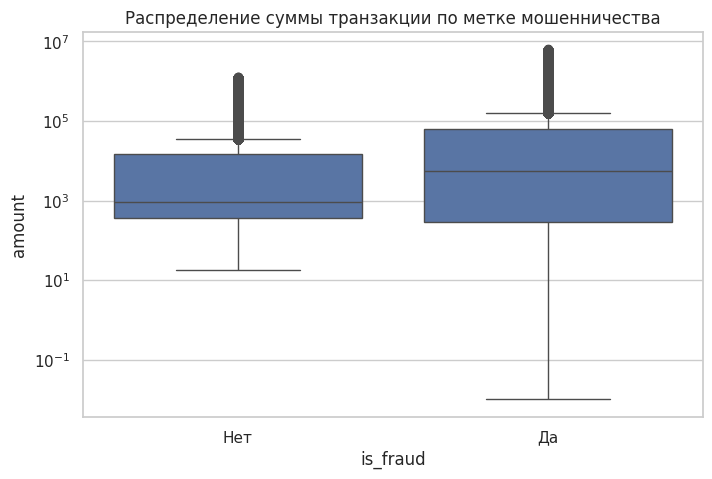

In [7]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_fraud', y='amount', data=df)
plt.yscale('log')
plt.title('Распределение суммы транзакции по метке мошенничества')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.show()

Дополнительно разобьём суммы транзакций на три группы



*   Низкое значение транзакции - до 33 процентиля
*   Среднее значение транзакции - от 33 до 66 процентиля
*   Высокое значение транзакции - выше 66 процентиля



Fraud rate по категориям суммы транзакций (%):
amount_category
High      18.08
Low       10.52
Medium     8.27
Name: is_fraud, dtype: float64


/tmp/ipython-input-8-4277158608.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_rate_by_amount.index, y=fraud_rate_by_amount.values, palette='muted')


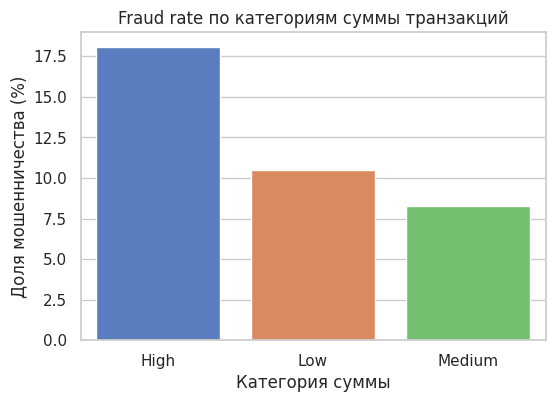

In [8]:
low_thresh = df['amount'].quantile(0.33)
high_thresh = df['amount'].quantile(0.66)

def categorize_amount(amount):
    if amount <= low_thresh:
        return 'Low'
    elif amount <= high_thresh:
        return 'Medium'
    else:
        return 'High'


df['amount_category'] = df['amount'].apply(categorize_amount)

fraud_rate_by_amount = df.groupby('amount_category')['is_fraud'].mean() * 100

print("Fraud rate по категориям суммы транзакций (%):")
print(fraud_rate_by_amount.round(2))

plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_rate_by_amount.index, y=fraud_rate_by_amount.values, palette='muted')
plt.ylabel('Доля мошенничества (%)')
plt.xlabel('Категория суммы')
plt.title('Fraud rate по категориям суммы транзакций')
plt.show()

Выоды:

**Высокие суммы (High)** — имеют значительно более высокий уровень мошенничества (28.16%), это ожидаемо, ведь крупные транзакции привлекают мошенников.

**Низкие суммы (Low)** показывают довольно высокий уровень мошенничества (17.02%), выше среднего. Это может означать, что мошенники также активно проводят мелкие транзакции, возможно, для того, чтобы не привлекать к себе лишнее внимание или отрабатывать мошеннические схемы.



Дополнительно проверим каналы проведения мошеннических транзакций

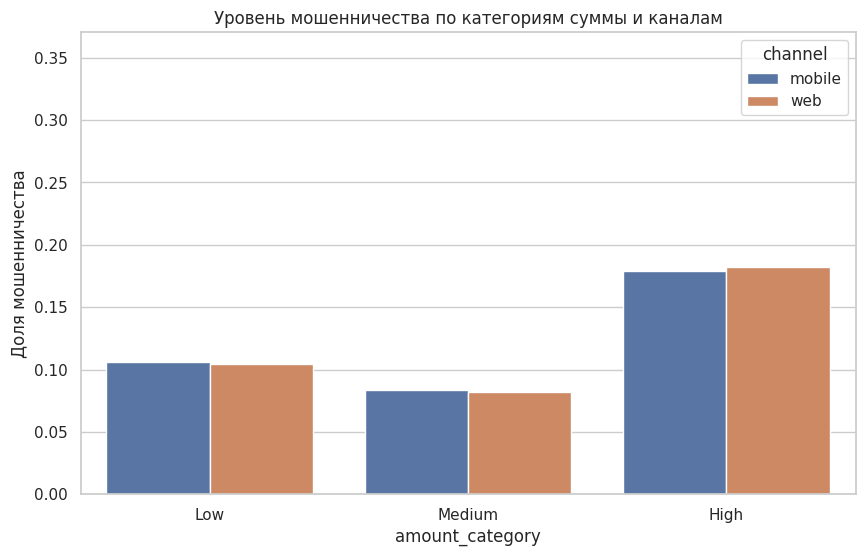

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='amount_category', y='is_fraud', hue='channel', errorbar=None)
plt.ylabel('Доля мошенничества')
plt.title('Уровень мошенничества по категориям суммы и каналам')
plt.ylim(0, df['is_fraud'].mean() * 3)
plt.show()

Как видно из графиков, уровень мошенничества между mobile и web находится на примерно одном уровне.

**Вывод:** Нет смысла сильно выделять один из этих каналов как более "опасный"